# PyOR also called Python On Resonance
## Vineeth Francis Thalakottoor
## vineeth.thalakottoor@ens.psl.eu or vineethfrancis.physics@gmail.com
## Example: 1D NMR Pulse and Acquisition

### Define the Path to PyOR source code << PythonOnResonance.py >>

In [14]:
SourcePath = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_V1/Source'

### Load Python packages

In [15]:
import sys
sys.path.append(SourcePath)

import PythonOnResonance_beta as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib ipympl
import sympy as sp
from sympy import *

### Define Spin System (Two Spin Half)

In [16]:
# Spin_list = [1/2] # Spin half
Spin_list = [1/2, 1/2] # Two spin half
# Spin_list = [1/2,1] # Spin half and spin one
# Spin_list = [1/2,1/2,1/2] # Three spin half
# Spin_list = [1/2,1/2,1/2,1/2] # Four spin half
# Define your own spin system

### Call PyOR Module
    - See the default setting/parameters

In [17]:
System = PyOR.Numerical_MR(Spin_list)


PyOR default parameters/settings
--------------------------------
Define energy units: hbarEQ1 =  True
Define the gyromagnetic ratios: Gamma =  [0, 0]
Define the static field along Z: B0 =  None
Define rotating frame frequency: OmegaRF =  [0, 0]
Define the offset frequencies of the spins: Offset =  [0, 0]
Define the J coupling: Jlist =  [[0. 0.]
 [0. 0.]]
Define the spin paris dipolar coupled: DipolePairs =  None
Initial spin temperature of individual spins: Ispintemp =  [0, 0]
Final spin temperature of individual spins =  [0, 0]
Define propagation space <<Hilbert>> or <<Liouville>>: PropagationSpace =  Hilbert
Define acquisition parameter, dwell time: AcqDT =  0.0001
Define acquisition parameter, acquisition time: AcqAQ =  5.0
Define acquisition parameter, acquisition points: AcqNPOINTS =  50000
Define relaxation process: Rprocess =  No Relaxation
Define longitudinal relaxation rate (phenominological): R1 =  0.0
Define transversel relaxation rate (phenominological): R2 =  0.0
Define 

### Generate spin operators: Sx, Sy, Sz, Sp and Sm

In [18]:

Sx,Sy,Sz,Sp,Sm = System.GenerateSpinOperators()
print(Sx.shape)
print(Sx[0].shape)
print(Sx[1].shape)

(2, 4, 4)
(4, 4)
(4, 4)


### Set parameters

In [19]:
# Gyromagnetic ratio of individual spins (Gamma[0] corresponds to spin 1)
System.Gamma[0] = System.gammaH1
System.Gamma[1] = System.gammaH1

# B0 Field in Tesla, Static Magnetic field (B0) along Z
System.B0 = 9.4

# Rotating Frame Frequency
System.OmegaRF[0] = -System.gammaH1*System.B0
System.OmegaRF[1] = -System.gammaH1*System.B0

# Offset Frequency in rotating frame (Hz)
System.Offset[0] = 10.0
System.Offset[1] = 20.0

# Define J coupling between Spins (Jlist[i][j], j > i)
System.Jlist[0][1] = 1

# Define paris of spins coupled by dipolar interaction
System.DipolePairs = [(0,1)]

# Define initial and final Spin Temperature
System.Ispintemp[0] = 300.0
System.Ispintemp[1] = 300.0
System.Fspintemp[0] = 300.0
System.Fspintemp[1] = 300.0

# Relaxation Process
System.Rprocess = "Phenomenological" # "No Relaxation" or
System.R1 = 1
System.R2 = 2

### product operator basis (Shift Z or PMZ basis)

In [20]:
sort = 'negative to positive'
Index = False
Normal = True
Basis_PMZ, coh_PMZ, dic_PMZ = System.ProductOperators_SpinHalf_PMZ(sort,Index,Normal)

### Generate Hamiltonians

In [21]:
# generate Larmor Frequencies
LarmorF = System.LarmorFrequency()

# Lab Frame Hamiltonian
Hz_lab = System.Zeeman()

# Rotating Frame Hamiltonian
Hz = System.Zeeman_RotFrame()

# J coupling Hamiltonian
Hj = System.Jcoupling()
# Hj = System.Jcoupling_Weak()

# Dipole coupling Hamiltonian
bIS = 25.0e3
theta = 45
phi = 45
secular = True
Hd = System.DDcoupling(bIS,theta,phi,secular)

Larmor Frequency in MHz:  [-400.22802765 -400.22803765]


### Initialize Density Matrix

In [22]:
Thermal_DensMatrix = False

if Thermal_DensMatrix:    
    # High Temperature
    HT_approx = False
    
    # Initial Density Matrix
    rho_in = System.EqulibriumDensityMatrix(System.Ispintemp,HT_approx)
    
    # Equlibrium Density Matrix
    rhoeq = System.EqulibriumDensityMatrix(System.Fspintemp,HT_approx)
else:
    rho_in = np.sum(Sz,axis=0)
    rhoeq = np.sum(Sz,axis=0)

System.DensityMatrix_Components_Dictionary(Basis_PMZ,dic_PMZ,rho_in)    

Density Matrix = 1.0 Iz1 Id2  + 1.0 Id1 Iz2 


### Pulse

In [23]:
flip_angle1 = 180.0   # Flip angle Spin 1
flip_angle2 = 180.0 # Flip angle Spin 2

rho = System.Rotate_Pulse(rho_in,flip_angle1,Sy[0])
rho = System.Rotate_Pulse(rho,flip_angle2,Sy[1]) 

System.DensityMatrix_Components_Dictionary(Basis_PMZ,dic_PMZ,rho)

Density Matrix = -0.0 Im1 Im2  + 0.70711 Im1 Id2  + 0.70711 Id1 Im2  + 0.0 Im1 Ip2  + 0.0 Iz1 Iz2  + 0.0 Iz1 Id2  + 0.0 Id1 Iz2  + -0.0 Id1 Id2  + 0.0 Ip1 Im2  + -0.70711 Id1 Ip2  + -0.70711 Ip1 Id2  + -0.0 Ip1 Ip2 


## Evolution 

In [24]:
System.AcqDT = 0.0001
System.AcqAQ = 5.0
System.OdeMethod = 'DOP853'
System.PropagationMethod = "ODE Solver"

start_time = time.time()
t, rho_t = System.Evolution(rhoeq,rho,Hz+Hj)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Total time = 2.346442461013794 seconds 


### Expectation Value

In [25]:
det_1 = Sp[0]
det_2 = Sp[1]

t, signal1 = System.Expectation(rho_t,det_1)
t, signal2 = System.Expectation(rho_t,det_2)

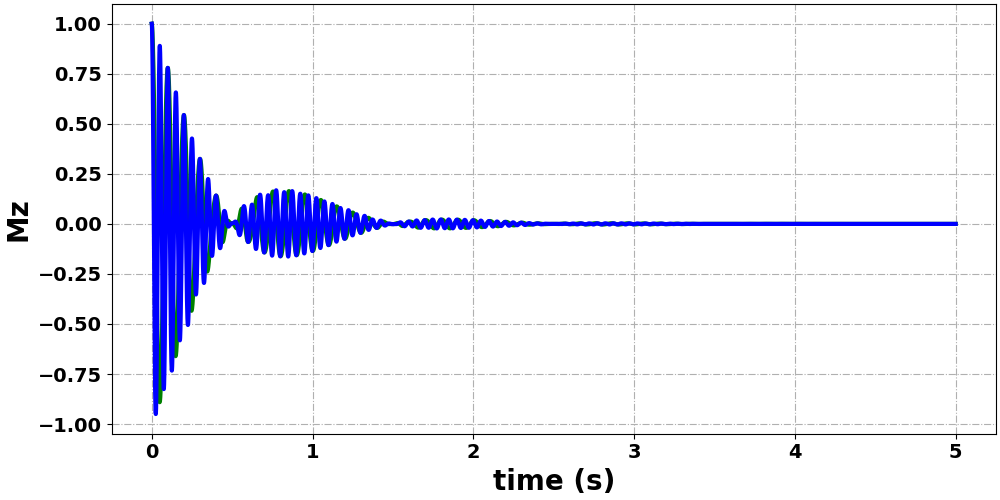

In [27]:
System.PlotFigureSize = (10,5)
System.PlotFontSize = 20
System.PlottingMulti(3,[t,t],[signal1,signal2],"time (s)","Mz",["green","blue"])